In [61]:
from pickle import TRUE
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import email.utils as eutils
import time
import streamlit as st
import eppy as eppy
from eppy import modeleditor
from eppy.modeleditor import IDF
from eppy.runner.run_functions import runIDFs
import PySimpleGUI as sg
from PIL import Image, ImageTk
import os
from eppy.results import readhtml # the eppy module with functions to read the html
from eppy.results import fasthtml
import subprocess
import os
from os import system

import pprint
pp = pprint.PrettyPrinter()

In [62]:
studyFolder = 'C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/PhiusREVIVE/Testing/test2'

fname = (str(studyFolder) + '/eplustbl.htm')
filehandle = open(fname, 'r').read()
ltables = readhtml.lines_table(filehandle) # reads the tables with their titles

for ltable in ltables:
    if 'Site and Source Energy' in '\n'.join(ltable[0]): #and 'For: Entire Facility' in '\n'.join(ltable[0]):
        eui = float(ltable[1][1][2])

for ltable in ltables:
    if 'Annual and Peak Values - Electricity' in '\n'.join(ltable[0]): #and 'For: Entire Facility' in '\n'.join(ltable[0]):
        peakElec = float(ltable[1][1][4])

print(eui)
print(peakElec)

15.22
4091.33


2023-03-21 15:54:11.192 WARNING matplotlib.legend: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


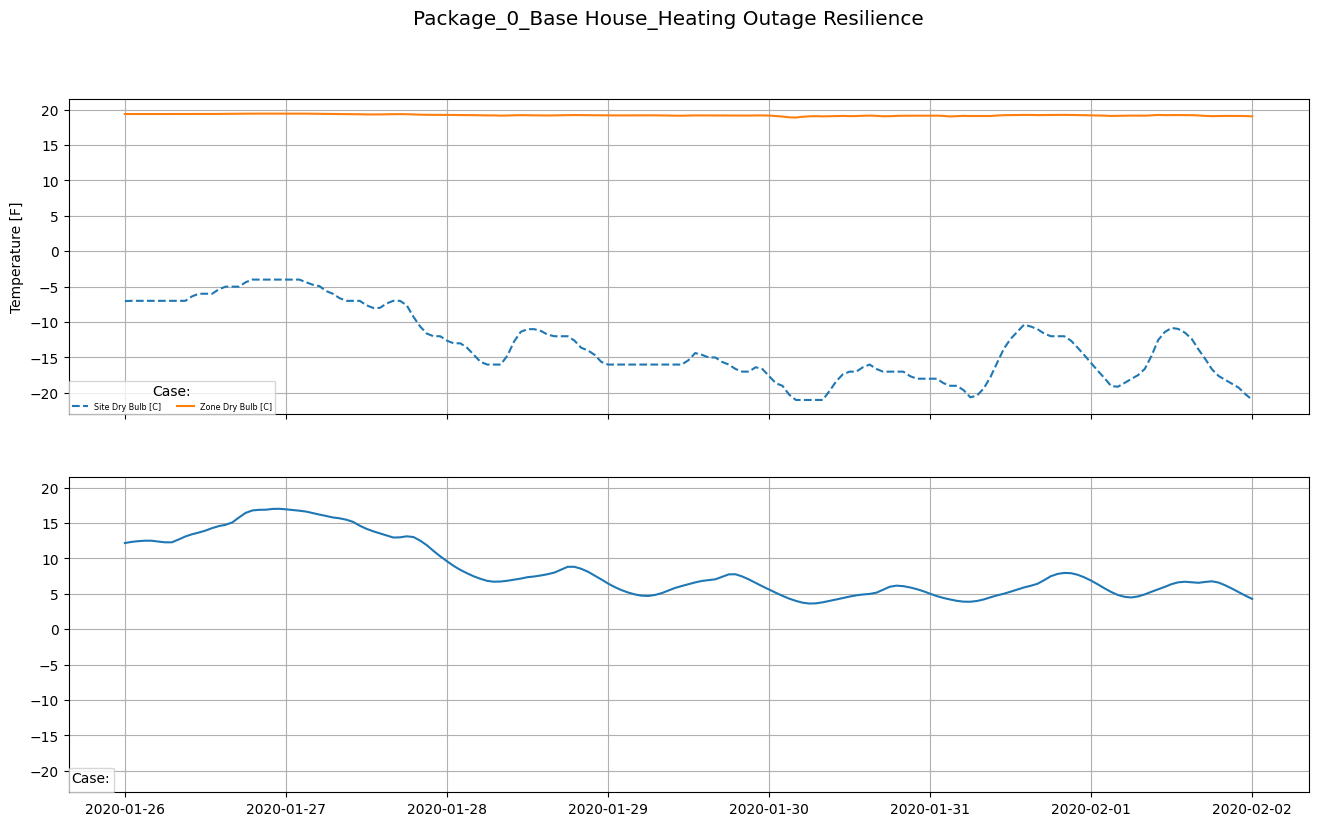

In [68]:
runListPath = 'C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/PhiusREVIVE/Testing/test2/runs.csv' # str(input('Select runs.csv'))
studyFolder = 'C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/PhiusREVIVE/Testing/test2' # str(input('Path to folder for study inputs: '))
idfgName = 'C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/PhiusREVIVE/Testing/PNNL_SF_Geometry.idf' # str(input('Path to EnergyPlus IDF file with building geometry: '))
runList = pd.read_csv(str(runListPath))
runCount = 0
caseName = runList['CASE_NAME'][runCount]

outage1start = runList['OUTAGE_1_START'][runCount]
outage1end = runList['OUTAGE_1_END'][runCount]
outage2start = runList['OUTAGE_2_START'][runCount]
outage2end = runList['OUTAGE_2_END'][runCount]
outage1type = runList['1ST_OUTAGE'][runCount]

if outage1type == 'HEATING':
    heatingOutageStart = outage1start
    heatingOutageEnd = outage1end
    coolingOutageStart = outage2start
    coolingOutageEnd = outage2end
else:
    heatingOutageStart = outage2start
    heatingOutageEnd = outage2end
    coolingOutageStart = outage1start
    coolingOutageEnd = outage1end 

#########################################################################################
filehandle = (str(studyFolder) + '\eplusout.csv')
hourly = pd.read_csv(filehandle)

hourly.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
hourly[['Date2','Time']] = hourly.DateTime.str.split(expand=True)
hourly['Date'] = hourly['Date2'].map(str) + '/' + str(2020)
hourly['Time'] = (pd.to_numeric(hourly['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + hourly['Time'].str[2:]
hourly['DateTime'] = hourly['Date'] + ' ' + hourly['Time']
hourly['DateTime'] = pd.to_datetime(hourly['DateTime'])

endWarmup = int((hourly[hourly['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

hourly = hourly.drop(index = dropWarmup)
hourly = hourly.reset_index()

heatingOutageStart = datetime.strptime((str(heatingOutageStart) + '/' + str(2020)), '%m/%d/%Y')
heatingOutageEnd = datetime.strptime((str(heatingOutageEnd) + '/' + str(2020)), '%m/%d/%Y')

mask = (hourly['DateTime'] >= heatingOutageStart) & (hourly['DateTime'] <= heatingOutageEnd)

hourlyHeat = hourly.loc[mask]

x = hourlyHeat['DateTime']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9), sharex=True, sharey=True,constrained_layout=False)
fig.suptitle((str(caseName) + '_Heating Outage Resilience'), fontsize='x-large')
ax1.plot(x,hourlyHeat["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb [C]", linestyle='dashed')
ax1.plot(x,hourlyHeat["ZONE 1:Zone Air Temperature [C](Hourly)"], label="Zone Dry Bulb [C]")
ax2.plot(x,hourlyHeat['ZONE 1:Zone Air Relative Humidity [%](Hourly)'], label=("_Zone RH"))
ax1.grid(True)
ax1.set_ylabel('Temperature [F]')
ax1.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='xx-small')
ax2.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='xx-small')
ax2.grid(True)

        


